In [ ]:
integrantes = ("Caicedo, Daniel", "Diaz Villa, Virginia", "Hruszecki, Darío", "Marchio, Sergio")

print("TP2 AA, grupo 2 \n")

for i in integrantes:
    print(i)

TP2 AA, grupo 2 

Caicedo, Daniel
Diaz Villa, Virginia
Hruszecki, Darío
Marchio, Sergio


## Import de librerias utilizadas

In [ ]:
import librosa
import glob
import numpy as np
import seaborn as sns
import pandas as pd

import os
import os.path
from os import path

import matplotlib.pyplot as plt

from enum import Enum
from time import time

from IPython.display import Audio
from librosa.display import specshow
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# para ejecutar desde google colab, con notebook en el directorio donde están los demás archivos
from google.colab import drive
drive.mount('/content/gdrive')

# directorio donde esté el notebook y los archivos de sonido
carpeta_tp = "AA_TP2"

os.chdir("gdrive/My Drive/" + carpeta_tp)
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/AA_TP2'

## Funciones para la obtención de features y modelado

In [ ]:
class AudioType(Enum):
  TRAIN = 1   
  VALIDATION = 2   
  TEST = 3   
  CUSTOM = 4   

In [ ]:
class Feature:
  def __init__(self, filename, audio_type, noise_type=None):
    self.filename = filename
    self.noise_type = noise_type
    self.audio_type = audio_type

In [ ]:
class Features(Enum):
    Train = Feature("train_features.csv",AudioType.TRAIN)
    Validation = Feature("valid_features.csv", AudioType.VALIDATION)
    Test = Feature("test_features.csv", AudioType.TEST) 
    Test_Noise_Gauss = Feature("test_features_gauss.csv",AudioType.TEST, "gauss")
    Test_Noise_Dishes = Feature("test_features_dishes.csv", AudioType.TEST, "doing_the_dishes.wav")
    Test_Noise_Dude = Feature("test_features_dude.csv", AudioType.TEST, "dude_miaowing.wav")
    Test_Noise_Bike = Feature("test_features_bike.csv", AudioType.TEST, "exercise_bike.wav")
    Test_Noise_Pink = Feature("test_features_pink.csv", AudioType.TEST, "pink_noise.wav")
    Test_Noise_Running = Feature("test_features_running.csv", AudioType.TEST, "running_tap.wav")            
    Test_Noise_White = Feature("test_features_white.csv", AudioType.TEST, "white_noise.wav")
    Test_Custom = Feature("test_features_custom.csv", AudioType.CUSTOM)

In [ ]:
def download_feature_if_needed(filename):
    if not path.exists("features/"+filename):
        url = "https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/features/"+filename
        !wget {url} -P features
    else:
        print("features/" + filename, " already exists! :)")

In [ ]:
audio_filenames = None

to_number = {
  "zero": 0,
  "one": 1,
  "two": 2,
  "three": 3,
  "four": 4,
  "five": 5,
  "six": 6,
  "seven": 7,
  "eight": 8,
  "nine": 9
}

def get_filenames():
    
    global audio_filenames
    
    if audio_filenames!= None:
        return audio_filenames
    
    if not path.exists("speechcommands"):
        !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
        !mkdir speechcommands
        !tar -xf speech_commands_v0.01.tar.gz -C speechcommands

    if not path.exists("customcommands"):
        !wget https://raw.githubusercontent.com/dhruszecki/cdatos-AA-TP2/master/resources/custom_commands.tar.gz
        !mkdir customcommands
        !tar -xf custom_commands.tar.gz -C customcommands
    
    numbers_filenames = []
    custom_filenames = []

    for i in to_number:
        numbers_filenames.append(glob.glob('speechcommands/' + i + '/*.wav'))
        custom_filenames = custom_filenames + glob.glob("customcommands/" + i + '/*.wav')

    test_filenames= ['speechcommands/' + e for e in open('speechcommands/testing_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    valid_filenames= ['speechcommands/' + e for e in open('speechcommands/validation_list.txt','r').read().splitlines() if e[:e.find('/')] in to_number]
    train_filenames= [e for n in range(10) for e in numbers_filenames[n] if (e not in test_filenames) and (e not in valid_filenames)]
    
        
    print('train_count:' , len(train_filenames))
    print('test_count:' , len(test_filenames))
    print('valid_count:' , len(valid_filenames))
    print('custom_count:' , len(custom_filenames))
    
    audio_filenames = {
      AudioType.TRAIN : train_filenames,
      AudioType.TEST : test_filenames,
      AudioType.VALIDATION : valid_filenames,
      AudioType.CUSTOM : custom_filenames 
    }
        
    return audio_filenames

In [ ]:
def apply_noise(audio, noise_type):
    ruido = None
    if noise_type == "gauss":
        ruido = np.random.normal(size=audio.shape)
    else:
        ruido, sr = librosa.core.load('speechcommands/_background_noise_/'+noise_type, sr=None)
        ruido = 0.5*ruido[5000:5000+len(audio)]        
    
    return ruido + audio

In [ ]:
def calculate_features(filename, n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std],
                       summary_names=['mean', 'std'], noise_type=None):  
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  if (noise_type != None):
        x = apply_noise(x, noise_type)

  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)

  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])

  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
  
  summary_features = np.append(summary_features, [to_number[filename.split('/')[1]], filename])

  return summary_features

In [ ]:
features_names= None
def name_features(filename = '', n_mfcc=12, delta=True, deltadelta=True, energy=True, summary_fn = [np.mean, np.std], summary_names=['mean', 'std']):
    global features_names
    
    if features_names!= None:
        return features_names
    
    features_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
    if energy: features_names = features_names + ['energy']
    features_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in features_names]
    if delta: d_names = ['d{}'.format(name) for name in features_names]
    if deltadelta: dd_names = ['dd{}'.format(name) for name in features_names]

    features_names = features_names + d_names + dd_names + ['digit', 'file']

    return features_names

In [ ]:
def calculate_features_if_needed(feature):
    result_path = "features/"+feature.filename
    result = []
    if not path.exists(result_path):
        print("Getting filenames")
        filenames = get_filenames()[feature.audio_type]        
        
        print("Calculating features for ", len(filenames), " rows -> ", result_path)
        features_names = name_features()
        features_data = [calculate_features(filename, noise_type= feature.noise_type) for filename in filenames]
        pd.DataFrame(data = features_data, columns = features_names).to_csv(result_path)
        
    
    print("Loading saved features <- ", result_path)
    result = pd.read_csv(result_path)
    
    return result

In [ ]:
def load_features(feature):
    features = pd.DataFrame(calculate_features_if_needed(feature))
    features.drop(['file', 'Unnamed: 0'], axis=1, inplace=True)
    print(pd.crosstab(index=features["digit"], columns="count", normalize=True))
    return features

In [ ]:
def printAccuracy(label, model, features): 
    print("Accuracy "+label+" : {:.3f}".format(model.score(features.drop('digit',axis=1).values, 
                                                   features.digit.values))) 

##  Obtenemos features

### Descargamos los features guardados previamente

In [ ]:
download_feature_if_needed("train_features.csv")
download_feature_if_needed("valid_features.csv")
download_feature_if_needed("test_features.csv")
download_feature_if_needed("test_features_gauss.csv")
download_feature_if_needed("test_features_dude.csv")
download_feature_if_needed("test_features_bike.csv")
download_feature_if_needed("test_features_pink.csv")
download_feature_if_needed("test_features_running.csv")
download_feature_if_needed("test_features_white.csv")
download_feature_if_needed("test_features_dishes.csv")
download_feature_if_needed("test_features_custom.csv")

features/train_features.csv  already exists! :)
features/valid_features.csv  already exists! :)
features/test_features.csv  already exists! :)
features/test_features_gauss.csv  already exists! :)
features/test_features_dude.csv  already exists! :)
features/test_features_bike.csv  already exists! :)
features/test_features_pink.csv  already exists! :)
features/test_features_running.csv  already exists! :)
features/test_features_white.csv  already exists! :)
features/test_features_dishes.csv  already exists! :)
features/test_features_custom.csv  already exists! :)


### Features de entrenamiento

In [ ]:
%%time
train_features = load_features(Features.Train.value)

Loading saved features <-  features/train_features.csv
col_0     count
digit          
0      0.100215
1      0.101611
2      0.100591
3      0.098872
4      0.098765
5      0.099033
6      0.100054
7      0.100698
8      0.099463
9      0.100698
CPU times: user 411 ms, sys: 66.1 ms, total: 477 ms
Wall time: 2.47 s


### Features de validación

In [ ]:
%%time
validation_features = load_features(Features.Validation.value)

Loading saved features <-  features/valid_features.csv
col_0     count
digit          
0      0.104250
1      0.092221
2      0.094627
3      0.099439
4      0.112269
5      0.097033
6      0.105052
7      0.105453
8      0.097434
9      0.092221
CPU times: user 73.5 ms, sys: 8.53 ms, total: 82 ms
Wall time: 848 ms


### Features de Desarrollo

In [ ]:
develop_features = validation_features.append(train_features, ignore_index=True)

### Features de test

#### Test Originales

In [ ]:
# Test Originales
%%time
test_features = load_features(Features.Test.value)

Loading saved features <-  features/test_features.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 75.5 ms, sys: 10.9 ms, total: 86.4 ms
Wall time: 956 ms


#### Test con ruidos agregados

In [ ]:
# Test con ruido Gausiano
%%time
test_features_gauss = load_features(Features.Test_Noise_Gauss.value)

Loading saved features <-  features/test_features_gauss.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 68.7 ms, sys: 12.9 ms, total: 81.5 ms
Wall time: 951 ms


In [ ]:
# Test con ruido doing_the_dishes
%%time
test_features_dishes = load_features(Features.Test_Noise_Dishes.value)

Loading saved features <-  features/test_features_dishes.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 71.9 ms, sys: 5.73 ms, total: 77.6 ms
Wall time: 596 ms


In [ ]:
# Test con ruido dude_miaowing
%%time
test_features_dude = load_features(Features.Test_Noise_Dude.value)

Loading saved features <-  features/test_features_dude.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 77.2 ms, sys: 3.64 ms, total: 80.8 ms
Wall time: 974 ms


In [ ]:
# Test con ruido exercise_bike
%%time
test_features_bike = load_features(Features.Test_Noise_Bike.value)

Loading saved features <-  features/test_features_bike.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 74.7 ms, sys: 2.28 ms, total: 76.9 ms
Wall time: 568 ms


In [ ]:
# Test con ruido pink_noise
%%time
test_features_pink = load_features(Features.Test_Noise_Pink.value)

Loading saved features <-  features/test_features_pink.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 76.3 ms, sys: 6.23 ms, total: 82.5 ms
Wall time: 614 ms


In [ ]:
# Test con ruido running_tap
%%time
test_features_running = load_features(Features.Test_Noise_Running.value)

Loading saved features <-  features/test_features_running.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 79.4 ms, sys: 4.41 ms, total: 83.8 ms
Wall time: 858 ms


In [ ]:
# Test con ruido white_noise
%%time
test_features_white = load_features(Features.Test_Noise_White.value)

Loading saved features <-  features/test_features_white.csv
col_0     count
digit          
0      0.097962
1      0.097179
2      0.103448
3      0.104624
4      0.099138
5      0.106191
6      0.095611
7      0.093652
8      0.100705
9      0.101489
CPU times: user 75.4 ms, sys: 1.6 ms, total: 77 ms
Wall time: 981 ms


#### Test con audios `custom`

In [ ]:
%%time
test_features_custom = load_features(Features.Test_Custom.value)

Loading saved features <-  features/test_features_custom.csv
col_0  count
digit       
0        0.1
1        0.1
2        0.1
3        0.1
4        0.1
5        0.1
6        0.1
7        0.1
8        0.1
9        0.1
CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 543 ms


# Modelos

## Naive Bayes

### Entrenamiento

In [ ]:
%%time

naive_bayes = GaussianNB()
naive_bayes.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
predict_nb1 = naive_bayes.predict(validation_features.drop('digit',axis=1).values)

printAccuracy("Training", naive_bayes, train_features)
printAccuracy("Validación", naive_bayes, validation_features)

print(classification_report(validation_features.digit.values, predict_nb1))

Accuracy Training : 0.541
Accuracy Validación : 0.537
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       260
           1       0.36      0.58      0.45       230
           2       0.37      0.48      0.42       236
           3       0.55      0.55      0.55       248
           4       0.72      0.53      0.61       280
           5       0.54      0.53      0.54       242
           6       0.50      0.58      0.54       262
           7       0.58      0.49      0.53       263
           8       0.74      0.56      0.63       243
           9       0.61      0.41      0.49       230

    accuracy                           0.54      2494
   macro avg       0.56      0.54      0.54      2494
weighted avg       0.57      0.54      0.54      2494

CPU times: user 106 ms, sys: 32.5 ms, total: 138 ms
Wall time: 136 ms


In [ ]:
# se entrena el modelo con conjunto de desarrollo
naive_bayes_dev = GaussianNB()
naive_bayes_dev.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)

# se evalúa sobre conjunto de test
predict_nb_test = naive_bayes_dev.predict(test_features.drop('digit',axis=1).values)

###  Matriz de Confusión 

CPU times: user 202 ms, sys: 98.1 ms, total: 300 ms
Wall time: 195 ms


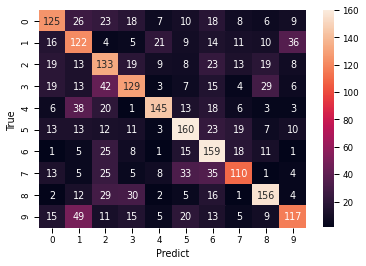

In [ ]:
%%time

sns.set_context('paper')
sns.heatmap(confusion_matrix(test_features.digit.values, predict_nb_test), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [ ]:
%%time

predict_nb_gauss = naive_bayes_dev.predict(test_features_gauss.drop('digit',axis=1).values)
predict_nb_dishes = naive_bayes_dev.predict(test_features_dishes.drop('digit',axis=1).values)
predict_nb_dude = naive_bayes_dev.predict(test_features_dude.drop('digit',axis=1).values)
predict_nb_bike = naive_bayes_dev.predict(test_features_bike.drop('digit',axis=1).values)
predict_nb_running = naive_bayes_dev.predict(test_features_running.drop('digit',axis=1).values)
predict_nb_pink = naive_bayes_dev.predict(test_features_pink.drop('digit',axis=1).values)
predict_nb_white = naive_bayes_dev.predict(test_features_white.drop('digit',axis=1).values)

printAccuracy("Develop", naive_bayes_dev, develop_features)

printAccuracy("Test", naive_bayes_dev, test_features)
print(classification_report(test_features.digit.values, predict_nb_test))

printAccuracy("Ruido Gaussiano", naive_bayes_dev, test_features_gauss)
print(classification_report(test_features_gauss.digit.values, predict_nb_gauss, zero_division=0))

printAccuracy("Ruido Doing the Dishes", naive_bayes_dev, test_features_dishes)
print(classification_report(test_features_dishes.digit.values, predict_nb_dishes, zero_division=0))

printAccuracy("Ruido Dude Miaowing", naive_bayes_dev, test_features_dude)
print(classification_report(test_features_dude.digit.values, predict_nb_dude, zero_division=0))

printAccuracy("Ruido Exercise Bike", naive_bayes_dev, test_features_bike)
print(classification_report(test_features_bike.digit.values, predict_nb_bike, zero_division=0))

printAccuracy("Ruido Running Tap", naive_bayes_dev, test_features_running)
print(classification_report(test_features_running.digit.values, predict_nb_running, zero_division=0))

printAccuracy("Ruido Pink Noise", naive_bayes_dev, test_features_pink)
print(classification_report(test_features_pink.digit.values, predict_nb_pink, zero_division=0))

printAccuracy("Ruido White Noise", naive_bayes_dev, test_features_white)
print(classification_report(test_features_white.digit.values, predict_nb_white, zero_division=0))



Accuracy Develop : 0.542
Accuracy Test : 0.531
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       250
           1       0.41      0.49      0.45       248
           2       0.41      0.50      0.45       264
           3       0.54      0.48      0.51       267
           4       0.71      0.57      0.63       253
           5       0.57      0.59      0.58       271
           6       0.48      0.65      0.55       244
           7       0.56      0.46      0.51       239
           8       0.62      0.61      0.61       257
           9       0.59      0.45      0.51       259

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552

Accuracy Ruido Gaussiano : 0.098
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       250
           1       0.00      0.00      0.00       24

### Impacto de los audios generados por el equipo en el rendimiento

In [ ]:
predict_nb_custom = naive_bayes_dev.predict(test_features_custom.drop('digit',axis=1).values)
printAccuracy("Custom", naive_bayes_dev, test_features_custom)
print(classification_report(test_features_custom.digit.values, predict_nb_custom))

Accuracy Custom : 0.225
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.27      0.35      0.30        20
           2       0.14      0.90      0.24        20
           3       0.00      0.00      0.00        20
           4       0.30      0.35      0.33        20
           5       0.47      0.40      0.43        20
           6       0.00      0.00      0.00        20
           7       0.67      0.10      0.17        20
           8       1.00      0.05      0.10        20
           9       0.50      0.05      0.09        20

    accuracy                           0.23       200
   macro avg       0.44      0.22      0.18       200
weighted avg       0.44      0.23      0.18       200



/home/daro/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest:  búsqueda de hiperparámetros óptimos

In [ ]:
%%time

parametros = {'n_estimators':range(100, 250, 15), 'max_depth':range(6, 12, 2), 'bootstrap':[True, False]}

clf = RandomizedSearchCV(RandomForestClassifier(random_state=22), parametros, n_jobs=20, random_state=131313,    
                         scoring='accuracy', n_iter=30, cv =  [(slice(None), slice(None))])

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
rf = clf.best_estimator_  

print(clf.best_score_, clf.best_params_)
printAccuracy("Training", rf, train_features)
printAccuracy("Validation", rf, validation_features)

0.8948979591836734 {'n_estimators': 220, 'max_depth': 10, 'bootstrap': False}
Accuracy Training : 0.895
Accuracy Validation : 0.664
CPU times: user 32.4 s, sys: 163 ms, total: 32.6 s
Wall time: 3min 3s


In [ ]:
parametros = {'n_estimators':220, 'max_depth':10, 'bootstrap':False}

clf = RandomizedSearchCV(RandomForestClassifier(random_state=22), parametros, n_jobs=20, random_state=131313,    
                         scoring='accuracy', n_iter=30, cv =  [(slice(None), slice(None))])

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
rf = clf.best_estimator_  

print(clf.best_score_, clf.best_params_)
printAccuracy("Training", rf, train_features)
printAccuracy("Validation", rf, validation_features)

In [ ]:
# se entrena el modelo con conjunto de desarrollo
rf.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)

naive_bayes_dev.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)

# se evalúa sobre conjunto de test
predict_nb_test = naive_bayes_dev.predict(test_features.drop('digit',axis=1).values)

###  Matriz de Confusión 

Text(32.7, 0.5, 'True')

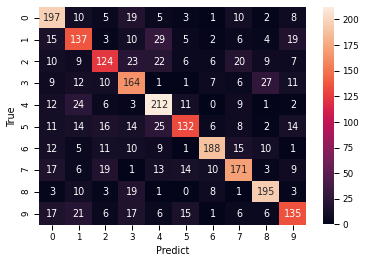

In [ ]:
rf_pred = rf.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, rf_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [ ]:
%%time

rf.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
printAccuracy("Develop", rf, develop_features)
printAccuracy("Test", rf, test_features)
printAccuracy("Ruido Gaussiano", rf, test_features_gauss)
printAccuracy("Ruido Doing the Dishes", rf, test_features_dishes)
printAccuracy("Ruido Dude Miaowing", rf, test_features_dude)
printAccuracy("Ruido Exercise Bike", rf, test_features_bike)
printAccuracy("Ruido Running Tap", rf, test_features_running)
printAccuracy("Ruido Pink Noise", rf, test_features_pink)
printAccuracy("Ruido White Noise", rf, test_features_white)

Accuracy Develop : 0.879
Accuracy Test : 0.644
Accuracy Ruido Gaussiano : 0.098
Accuracy Ruido Doing the Dishes : 0.325
Accuracy Ruido Dude Miaowing : 0.621
Accuracy Ruido Exercise Bike : 0.365
Accuracy Ruido Running Tap : 0.207
Accuracy Ruido Pink Noise : 0.116
Accuracy Ruido White Noise : 0.101
CPU times: user 34.5 s, sys: 0 ns, total: 34.5 s
Wall time: 34.5 s


### Impacto de los audios generados por el equipo en el rendimiento


In [ ]:
%%time

printAccuracy("Ruido Custom", rf, test_features_custom)

Accuracy Ruido Custom : 0.445
CPU times: user 24 ms, sys: 3.95 ms, total: 28 ms
Wall time: 26.2 ms


## Gradient Boosting

In [ ]:
%%time

parameters = {'n_estimators':range(50, 150, 25), 'max_depth':range(5,7), 'learning_rate':np.arange(0,1,0.1)}
clf = RandomizedSearchCV(GradientBoostingClassifier(random_state=22), parameters, n_jobs=-1, scoring='accuracy',cv=[(slice(None), slice(None))], n_iter=50, random_state=8)

clf.fit(train_features.drop('digit',axis=1).values, train_features.digit.values)
gb = clf.best_estimator_

print (clf.best_score_, clf.best_params_)
printAccuracy("Training", gb, train_features)
printAccuracy("Validation", gb, validation_features)

1.0 {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.2}
Accuracy Training : 1.000
Accuracy Validation : 0.741
CPU times: user 15min 37s, sys: 73.1 ms, total: 15min 37s
Wall time: 2h 38min 22s


###  Matriz de Confusión 

Text(32.7, 0.5, 'True')

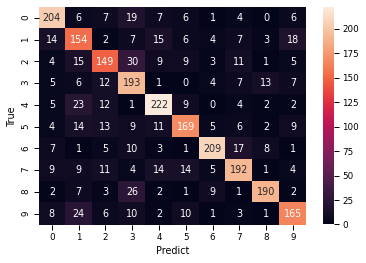

In [ ]:
gb_pred = gb.predict(validation_features.drop('digit',axis=1).values)
sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, gb_pred), annot=True, fmt='g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [ ]:
%%time

gb.fit(develop_features.drop('digit',axis=1).values, develop_features.digit.values)
printAccuracy("Develop", gb, develop_features)
printAccuracy("Test", gb, test_features)
printAccuracy("Ruido Gaussiano", gb, test_features_gauss)
printAccuracy("Ruido Doing the Dishes", gb, test_features_dishes)
printAccuracy("Ruido Dude Miaowing", gb, test_features_dude)
printAccuracy("Ruido Exercise Bike", gb, test_features_bike)
printAccuracy("Ruido Running Tap", gb, test_features_running)
printAccuracy("Ruido Pink Noise", gb, test_features_pink)
printAccuracy("Ruido White Noise", gb, test_features_white)

Accuracy Develop : 1.000
Accuracy Test : 0.745
Accuracy Ruido Gaussiano : 0.102
Accuracy Ruido Doing the Dishes : 0.414
Accuracy Ruido Dude Miaowing : 0.688
Accuracy Ruido Exercise Bike : 0.457
Accuracy Ruido Running Tap : 0.313
Accuracy Ruido Pink Noise : 0.125
Accuracy Ruido White Noise : 0.120
CPU times: user 20min 40s, sys: 53.5 ms, total: 20min 40s
Wall time: 20min 40s


### Impacto de los audios generados por el equipo en el rendimiento

In [ ]:
%%time

printAccuracy("Ruido Custom", gb, test_features_custom)

Accuracy Ruido Custom : 0.485
CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 15.3 ms


## MLP - *perceptrón multicapa*

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler

In [ ]:
# se cargan los conjuntos de entrenamiento y validación
# aplicando one hot encoding al conjunto de etiquetas
# y normalizando las inputs
def mlp_sets(full_dataframe, label_name):
    ohe = OneHotEncoder()
    scaler = StandardScaler()

    mlp_input = scaler.fit_transform(np.array(full_dataframe.drop(label_name, axis = 1)))
    mlp_labels = ohe.fit_transform(np.array(full_dataframe[label_name]).reshape(-1,1)).toarray()
 
    return mlp_input, mlp_labels

mlp_train_features, mlp_train_labels = mlp_sets(train_features, 'digit')
mlp_validation_features, mlp_validation_labels = mlp_sets(validation_features, 'digit')

mlp_develop_features, mlp_develop_labels = mlp_sets(develop_features, 'digit')
mlp_test_features, mlp_test_labels = mlp_sets(develop_features, 'digit')

In [ ]:
def entrenar_mlp(hyperparams, train, test, verbose = 1):
    tf.random.set_seed(1337)

    # "capa" de entrada
    layer_in = tfkl.Input(shape = 78)
    # capa oculta
    layer_hidden = tfkl.Dense(units = hyperparams['units'], activation = hyperparams['activation'])(layer_in)
    # capa de salida
    # Activación softmax fuerza que las probabilidades sumen 1
    layer_out = tfkl.Dense(units = 10, activation = 'softmax')(layer_hidden)

    mlp_model = tf.keras.Model(inputs = [layer_in], outputs = [layer_out])

    mlp_model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]
    metric_names = ['loss', 'accuracy', 'precision', 'recall', 'auc']

    mlp_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = metrics_list)

    # callbacks
    cb_list = [tf.keras.callbacks.TensorBoard(log_dir = 'tblogs'),
           tf.keras.callbacks.ModelCheckpoint(filepath = 'checkpoints'),
           tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)]

    # entrena modelo
    mlp_model.fit(x = train[0],
                  y = train[1],
                  validation_data = (test[0], test[1]),
                  batch_size = hyperparams['batch_size'],
                  epochs = 50, verbose = verbose, callbacks = cb_list)
    
    performance = mlp_model.evaluate(x = test[0], y = test[1])
    performance = dict(zip(metric_names, performance))

    return mlp_model, performance, hyperparams

### TensorBoard

In [ ]:
# esto probablemente sea la causa de los cuelgues

#%load_ext tensorboard
#%tensorboard --logdir 'tblogs'

### Búsqueda de hiperparámetros y entrenamiento del mejor modelo

In [ ]:
%time
# se realiza la búsqueda de hiperparámetros
hyperparameter_space = {'units': np.arange(10, 1000, 20),
                        'activation': ['relu', 'tanh', 'sigmoid', 'elu'],
                        'batch_size':[2**n for n in range(4, 10)]}
hyperparameters = list(ParameterSampler(hyperparameter_space, n_iter = 50, random_state = 12))

# busco maximizar accuracy
mlp_best_acc = 0
mlp_best_model = None
mlp_best_hparams = None
print("Busqueda de hiperparametros")
for hparams in hyperparameters:
    model, perf, hparams = entrenar_mlp(hparams,
                                        (mlp_train_features, mlp_train_labels),
                                        (mlp_validation_features, mlp_validation_labels),
                                        verbose = 0)
    if perf['accuracy'] > mlp_best_acc:
        mlp_best_acc = perf['accuracy']
        mlp_best_model = model
        mlp_best_hparams = hparams
    print("hparams:", hparams)

# por si se cuelga todo, que quede guardado en el output del nb
print(mlp_best_hparams)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Busqueda de hiperparametros
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 78)]              0         
_________________________________________________________________
dense_102 (Dense)            (None, 490)               38710     
_________________________________________________________________
dense_103 (Dense)            (None, 10)                4910      
Total params: 43,620
Trainable params: 43,620
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: checkpoints/assets
INFO:tensorflow:Assets written to: checkpoints/assets
INFO:tensorflow:Assets written to: checkpoints/assets
INFO:tensorflow:Assets written to: checkpoints/assets
INFO:tensorflow:Assets written to: checkpoints/assets
INFO:tensorflow:Assets

In [ ]:
# se evalúa el modelo en el conjunto de entrenamiento para comparar accuracy
metric_names = ['loss', 'accuracy', 'precision', 'recall', 'auc']

mlp_acc_train = mlp_best_model.evaluate(x = mlp_train_features, y = mlp_train_labels)
mlp_acc_train = dict(zip(metric_names, mlp_acc_train))

print("Accuracy Training:", round(mlp_acc_train['accuracy'], 4))
print("Accuracy Validation:", round(mlp_best_acc, 4))
print("\nMejores Hiperparámetros:")
for i, j in mlp_best_hparams.items():
    print("{}: {}".format(i, j))

582/582 [==============================] - 0s 835us/step - loss: 0.3727 - categorical_accuracy: 0.8861 - precision_25: 0.9325 - recall_25: 0.8476 - auc_25: 0.9915
Accuracy Training: 0.8861
Accuracy Validation: 0.7951

Mejores Hiperparámetros:
units: 290
batch_size: 512
activation: elu


### Matriz de Confusión

Text(32.7, 0.5, 'True')

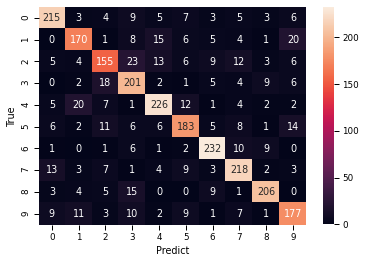

In [ ]:
# Obtiene las clases para el set de validación
mlp_pred = mlp_best_model.predict(x = mlp_validation_features).argmax(axis = -1)

sns.set_context('paper')
sns.heatmap(confusion_matrix(validation_features.digit.values, mlp_pred), annot = True, fmt = 'g')
plt.xlabel('Predict')
plt.ylabel('True')

### Impacto del ruido en el rendimiento 

In [ ]:
%time
# se entrena el modelo con el conjunto de desarrollo
mlp_dev_model, dev_perf, hparams = entrenar_mlp(mlp_best_hparams,
                                                (mlp_develop_features, mlp_develop_labels),
                                                (mlp_test_features, mlp_test_labels))


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 78)]              0         
_________________________________________________________________
dense_100 (Dense)            (None, 290)               22910     
_________________________________________________________________
dense_101 (Dense)            (None, 10)                2910      
Total params: 25,820
Trainable params: 25,820
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
42/42 [==============================] - 1s 24ms/step - loss: 1.5562 - categorical_accuracy: 0.5011 - precision_50: 0.8705 - recall_50: 0.1734 - auc_50: 0.8619 - val_loss: 1.0691 - val_categorical_accuracy: 0.6798 - val_precision_50: 0.8753 - val_recall_50: 0.4137 - val_auc_50: 0.9418
Epoch 2/50
42/42 [=====

In [ ]:
# se evalúa la performance en los distintos conjuntos de evaluación
dev_dev_accuracy = mlp_best_model.evaluate(x = mlp_train_features, y = mlp_train_labels)[1]

print("Accuracy Develop:", dev_dev_accuracy)
print("Accuracy Test:", dev_perf['accuracy'])

# se calcula la performance en distintas condiciones de ruido
test_ruidos = {"Ruido Gaussiano": test_features_gauss,
               "Ruido Doing the Dishes": test_features_dishes,
               "Ruido Dude Miaowing": test_features_dude,
               "Ruido Exercise Bike": test_features_bike,
               "Ruido Running Tap": test_features_running,
               "Ruido Pink Noise": test_features_pink,
               "Ruido White Noise": test_features_white}

for nombre, df in test_ruidos.items():
    inputs, label = mlp_sets(df, 'digit')
    acc = mlp_best_model.evaluate(x = inputs, y = label, verbose = 0)[1]
    print("Accuracy {}: {}".format(nombre, round(acc, 4)))

582/582 [==============================] - 0s 852us/step - loss: 0.3727 - categorical_accuracy: 0.8861 - precision_25: 0.9325 - recall_25: 0.8476 - auc_25: 0.9915
Accuracy Develop: 0.8860902190208435
Accuracy Test: 0.898692786693573
Accuracy Ruido Gaussiano: 0.1321
Accuracy Ruido Doing the Dishes: 0.5764
Accuracy Ruido Dude Miaowing: 0.7629
Accuracy Ruido Exercise Bike: 0.6591
Accuracy Ruido Running Tap: 0.5709
Accuracy Ruido Pink Noise: 0.3828
Accuracy Ruido White Noise: 0.3346


### Impacto de los audios generados por el equipo en el rendimiento

In [ ]:
mlp_custom = mlp_sets(test_features_custom, 'digit')
acc_custom = mlp_best_model.evaluate(x = mlp_custom[0], y = mlp_custom[1])[1]
print("Accuracy Ruido Custom:", round(acc_custom, 4))

7/7 [==============================] - 0s 1ms/step - loss: 1.0961 - categorical_accuracy: 0.6050 - precision_25: 0.6784 - recall_25: 0.5800 - auc_25: 0.9383
Accuracy Ruido Custom: 0.605


# Anexos

## Tratamiento audios grabados por el equipo

In [ ]:
# lista para guardar los audios nuestros (están en carpeta "audios")
# nparray (salida de librosa), fs, filename
audios_nos = []

for filename in os.listdir("audios"):
    if filename.endswith(".wav"):
        x, fs = librosa.core.load('audios/' + filename, sr = 16000)
        audios_nos += [[x] + [fs] + [filename]]
        #display(Audio(x, rate = fs))
        #plt.figure(figsize = (15,5))
        #plt.plot(x)
        print(filename)


In [ ]:
# el metodo de separar los audios con split_points = librosa.effects.split(x, top_db = top_db)
# se hace engorroso pues cambiando top_db se empieza a perder info del audio
# es compromiso entre que separe ruidos como audios extra y que se entiendan los numeros...
# y a veces no se logra => nuevo método

# la idea es dividirlos por el punto medio entre los maximos
# teninendo en cuenta que los dígitos se grabaron bastante separados 
# y aproximadamente equiespaciados

def get_audio_split_points(x, aname = '', start_div = 0, n_audios = 11, listen = False, plot = False):
    # busco los máximos del audio "x", para eso defino:
    # start: un punto de comienzo (por si hay 'clicks' al principio del audio)
    # win_length: un ancho de ventana para buscar el maximo
    # windows: las posiciones de las ventanas en funcion de esos parámetros, conservando las 11 primeras para delimitar los digitos
    win_length = len(x)//n_audios
    if start_div == 0:
        start = 0
    else:
        start = win_length//start_div
    
    windows = range(start, len(x), win_length)

    # encuentra la posicion del máximo en cada ventana
    maximos = [i + np.where(x[i:] == max(x[i:i + win_length]))[0][0] for i in windows[:-1]]
    # calcula las coordenadas de los cortes como el promedio entre las posiciones de los maximos
    split_coords = [(maximos[s] + maximos[s+1])//2 for s in range(len(maximos) - 1)]
    # el ultimo corte es sumando la distancia del ultimo maximo al corte anterior
    split_coords += [maximos[-1] + maximos[-1] - split_coords[-1]]
    # el primer corte es restando la distancia del final del primer audio a su maximo
    split_coords.insert(0, maximos[0] - (split_coords[0] - maximos[0]))

    # genera las coordenadas de cada sub-audio como [inicio, fin] y las junta en un array
    split_points = [[split_coords[i], split_coords[i+1]]  for i in range(len(split_coords) - 1)]

    if (plot | listen) == True:
        plt.figure(figsize=(15,5))
        plt.plot(x, color = 'k')

        for xc in windows:
            plt.axvline(x = xc, color = '#55CC5588')
        for xc in maximos:
            plt.axvline(x = xc, color = '#AA000088')
        for xc in split_coords:
            plt.axvline(x = xc, color = 'k', linestyle = 'dashed')

        # grafico el audio con las divisiones para verificar, más widgets para escucharlos
        print(aname, 'k = ', k)
        for split in split_points:
            if listen == True:
                display(Audio(x[split[0]:split[1]], rate = fs))
            if plot == True:
                xplot = np.zeros_like(x)
                xplot[split[0]:split[1]] = x[split[0]:split[1]]
                plt.plot(xplot)
        if plot == True:
            plt.show()
        print('\n')

    return split_points

In [ ]:

# no itero en los elementos directamente pues necesito saber el indice de alguno que no se haya partido bien
# para analizarlo luego. este es un analisis exploratorio en cierto sentido
for k in range(len(audios_nos)):
    get_audio_split_points(audios_nos[k][0], aname = audios_nos[k][-1], start_div = 2, n_audios = 11, listen = True, plot = True)
 
# se observa que para todos los elementos menos
# 13 17 18
# funciona bien start_div = 2

In [ ]:
# analizamos los casos puntuales
# para 18 anda bien 1
# apra 13 y 17 anda bien 3
for k in (13, 17):
    get_audio_split_points(audios_nos[k][0], aname = audios_nos[k][-1], start_div = 3, n_audios = 11, listen = True, plot = True)
 

In [ ]:
# lista con el parametro de corte de cada audio
audios_start_div = [1 if i == 18 else (3 if i == 13 or i == 17 else 2) for i in range(len(audios_nos))]

# exporta audios
!pip install soundfile
import soundfile as sf

# si no existe la carpeta con los audios la crea y crea las subfolders con
# los nombres de los digitos
audios_nos_folder = "espichcomans"
if not os.path.exists(audios_nos_folder):
    os.mkdir(audios_nos_folder)

    for key in to_number.keys():
        os.mkdir(audios_nos_folder + '/' + key)


# para cada audio lo splitea y guarda los digitos
for k in range(len(audios_nos)):
    filename = audios_nos[k][-1].split('.')[0]
    audiox = audios_nos[k][0]
    fs = audios_nos[k][1]

    split_points = get_audio_split_points(audiox,
                                          aname = audios_nos[k][-1],
                                          start_div = audios_start_div[k],
                                          n_audios = 11,
                                          listen = False, plot = False)
    
    # necesito los indices para saber que numero es :)
    # algunas variables solamente por cuestion de legibilidad no lo dejo todo compactado
    for j in range(len(split_points)):
        folder = audios_nos_folder + '/' + list(to_number.keys())[j]
        start, end = split_points[j]
        sf.write("{}/{}_{}.wav".format(folder, filename, j), audiox[start:end], fs)
